In [1]:
#import packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#packages for svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#packages for linear regression
from sklearn.linear_model import LinearRegression

#packages for
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Data Cleaning for Reef Base Data Set

In [2]:
# import the data set
coral_df = pd.read_excel('CoralBleaching.xlsx')

In [3]:
#changing types on the objects for future analysis
coral_df['REGION']  = coral_df['REGION'].astype('string')
coral_df['SUBREGION']  = coral_df['SUBREGION'].astype('string')
coral_df['COUNTRY']  = coral_df['COUNTRY'].astype('string')

#location is the most spefifc marker, will be harder to group by
coral_df['LOCATION']  = coral_df['LOCATION'].astype('string')

#depth is stored as integers, floats, ranges of values. Will need to be turned into single floats
coral_df['DEPTH']  = coral_df['DEPTH'].astype('string')

#severity code is measured with a string: Severity Unknown, No Bleaching, Low, Medium, High
#will be stored as strings
coral_df['BLEACHING_SEVERITY']  = coral_df['BLEACHING_SEVERITY'].astype('string')

#coral family and species will both be stored as strings
coral_df['CORAL_FAMILY']  = coral_df['CORAL_FAMILY'].astype('string')
coral_df['CORAL_SPECIES']  = coral_df['CORAL_SPECIES'].astype('string')
#note! coral species entries often has several species inside it, 
#when doing group analysis this could be taken into account, use string methods like contains instead of ==

#percentage affected has a similar issue to depth, some are ints some have percentages behind them, some are ranges
#needs to be stored as a single float
coral_df['DEPTH']  = coral_df['DEPTH'].astype('string')

# another issue with the depth column is that some of the entries are measured in ft and some in m while many of 
# them have no label at all
# For the unlabeled measurements I am going to assume that they are in meters unless the country is the US in which
# case we will disregard the measurement as some US scientists measure in imperial and some in metric

#check if what has been given is float and it it is not, just return an empty string (null value)
def try_float(s):
  try:
    float(s)
    return float(s)
  except:
    return None


def depth_clean(s, c):
    #check so it does not run on null values
    if type(s) == str:
        if s.find('ft')!=-1:
            return ft_clean(s)
        elif s.find('m')!=-1:
            return m_clean(s)
        else:
            if c.find('USA')!=-1:
                return None
            else:
                return m_clean(s)

def m_clean(s):
    # check is there is an m
    # this is also called on the values with no length lable
    if s.find('m')!=-1:
        i = s.index('m')
        s = s[:i]
    #check if there is a - symbol 
    if s.find('-')!=-1:
        #slice the substring to exclude the - and everything afterwards
        #this will mean that for ranges we are taking the smaller value
        i = s.index('-')
        s = s[:i]
    #check if there is a < symbol
    if s.find('<') !=-1:
        i = s.index('<')
        s = s[i+1:]
    #check if there is a > symbol
    if s.find('>') !=-1:
        i = s.index('>')
        s = s[i+1:]
    return try_float(s)
    
def ft_clean(s):
    i = s.index('ft')
    s = s[:i]
    #check if there is a - symbol 
    if s.find('-')!=-1:
        #slice the substring to exclude the - and everything afterwards
        #this will mean that for ranges we are taking the smaller value
        i = s.index('-')
        s = s[:i]
    #check if there is a < symbol
    if s.find('<') !=-1:
        i = s.index('<')
        s = s[i+1:]
    #check if there is a > symbol
    if s.find('>') !=-1:
        i = s.index('>')
        s = s[i+1:]
    s = try_float(s)
    if type(s) == float:
        return s * 0.3048

#converting country code to string for comparison in the function  
coral_df['COUNTRY_CODE']  = coral_df['COUNTRY_CODE'].astype('string')

coral_df['DEPTH_CLEANED'] = coral_df.apply(lambda x: depth_clean(x['DEPTH'], x['COUNTRY_CODE']), axis=1)

#bleaching duration looks to be unusable, most of the columns are left blank 
#and those that are not are sparce with information, a lot are missing years and we cannot be sure that it is the 
#year of publication (2016) as the data goes back to 1963, we recommend it is dropped

#We cannot find the documentation for revocery code and recovery, but it is easier to intuit what these mean
#for morality code
# - 3 means that the coral has started a small amount of recovery
# - 2 means the coral has achived 50% recoveray
# - 0 means the coral is fully recovered
# it is inconclusive what 1 means, but it can be intuited that it means that the coral is close to full recovery
#I do not think this data can provide useful insight. It only has 91 non null values in addition to the fact 
#that I am not fully sure what  those values mean

#survey type can be stored as string

#percantge effected needs to be cleaned as some of the values are stored as range of percentages, 
#some as ints, some as floats and some with the %, ideally we want all these values to be single floats with no 
#other symbols for analysis
coral_df['PERCENTAGE_AFFECTED']  = coral_df['PERCENTAGE_AFFECTED'].astype('string')

#take in the string that rerpresnts the percenage and make it a single float
def percentage_clean(s):
    #check so it does not run on null values
    if type(s) == str:
        #check if there is a % symbol
        if s.find('%')!=-1:
            #slice the substring to exclude the % and everything afterwards
            i = s.index('%')
            s = s[:i]
        #check if there is a - symbol 
        if s.find('-')!=-1:
            #slice the substring to exclude the - and everything afterwards
            #this will mean that for ranges we are taking the smaller value
            i = s.index('-')
            s = s[:i]
        #check if there is a < symbol
        if s.find('<') !=-1:
            i = s.index('<')
            s = s[i+1:]
        #check if there is a > symbol
        if s.find('>') !=-1:
            i = s.index('>')
            s = s[i+1:]
        return try_float(s)
    
coral_df['PERCENTAGE_AFFECTED_CLEANED'] = coral_df['PERCENTAGE_AFFECTED'].apply(percentage_clean)

In [4]:
def clean_temp(df):
    '''Function to clean temperature column'''
    for i, row in df.iterrows():
        temp = row['WATER_TEMPERATURE']
        # check if temperature could be a float
        if try_float(temp):
            # if yes and val is less than 40 (celcius), convert to float
            if float(temp) < 40:
                df.loc[i, ['WATER_TEMPERATURE']] = float(temp)
        else:
            # if not, clean up string
            number_lst = []
            # split by spaces
            str_lst = temp.split(' ')
            # iterate over words
            for a_str in str_lst:
                # check if it could be a float
                # remove any symbols in the strings
                character_lst = ['c', 'C', 'f' '°C', 'Celcius', 'celcius', 'deg', 'oC', '°', 'o']
                for character in character_lst:
                    num = a_str.replace(character, '')
                if try_float(a_str):
                    # check if value is less than 40 and convert to float
                    if float(a_str) < 40:
                        # if it is a range of values, append it to list 
                        number_lst.append(float(a_str))
                # check if it uses '-' for the range
                elif '-' in a_str:
                    # split the word by '-'
                    num_range = a_str.split('-')
                    # iterate over the 2 number strings
                    for num in num_range:
                        # remove any symbols in the strings
                        character_lst = ['c', 'C', 'f' '°C', 'Celcius', 'celcius', 'deg', 'oC', '°', 'o']
                        for character in character_lst:
                            num = num.replace(character, '')
                        # convert to float and append to list
                        if try_float(num):
                            if float(num) < 40:
                                number_lst.append(float(num))
            # try to get the mean of values in the list of numbers
            try: 
                df.loc[i, ['WATER_TEMPERATURE']] = sum(number_lst) / len(number_lst)
            except:
                df.loc[i, ['WATER_TEMPERATURE']] = None
        
    return df      

def try_float(string):
    '''Function to check if string could be float'''
    try:
        a_float = float(string)
        if type(a_float) == float:
            return True
    except:
        return False
    
coral_df = clean_temp(coral_df)

## Algorithm 1: Making a Support Vector Machine to Predict Sevarity Labels for Supp Data Set for Vizulization

In [5]:
#remove all serviety codes that are -1 bc that means sevaity unknown and is not good for us
coral_svm_df = coral_df[coral_df['SEVERITY_CODE'] != -1]
coral_svm_df['SEVERITY_CODE'].value_counts()

SVM_df = coral_df[['SEVERITY_CODE', 'DEPTH_CLEANED', 'LAT', 'LON', 'YEAR']]
SVM_df = SVM_df.dropna()
SVM_df.rename(columns={"DEPTH_CLEANED": "DEPTH"}, inplace = True)
SVM_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2909 entries, 0 to 6186
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SEVERITY_CODE  2909 non-null   int64  
 1   DEPTH          2909 non-null   float64
 2   LAT            2909 non-null   float64
 3   LON            2909 non-null   float64
 4   YEAR           2909 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 136.4 KB


In [6]:
#partition the data
X   = SVM_df[['DEPTH', 'LAT', 'LON', 'YEAR']] #get the input features
y   = SVM_df['SEVERITY_CODE']              #get the target

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

In [7]:
X_train = X_train.copy()
X_test  = X_test.copy()

In [8]:
#normalize the numeric features
scaler = StandardScaler()
scaler.fit(X_train[['DEPTH', 'LAT', 'LON', 'YEAR']])

X_train[['DEPTH', 'LAT', 'LON', 'YEAR']] = scaler.transform(X_train[['DEPTH', 'LAT', 'LON', 'YEAR']]) #scale the training data

In [9]:
#view the prepared data
X_train.head(10)

,DEPTH,LAT,LON,YEAR
2072,0.212923,0.041190,-0.594965,-1.103600
2868,0.607820,0.033849,1.080712,1.357195
1245,1.496337,0.077256,-0.774804,0.238652
2751,0.076228,0.010893,0.893463,1.133487
1819,1.564685,0.084689,-0.644040,-1.103600
1025,-0.311074,0.076884,-0.774581,0.462361
1088,1.754539,0.076459,-0.774583,0.238652
203,1.063470,-0.028915,0.474966,-1.327309
1230,-0.508522,0.077461,-0.774919,0.238652
258,0.911587,0.066285,-0.561228,-1.103600


In [10]:
#initialize the classifier

svm = SVC() #the default kernel is rbf
svm.fit(X_train, y_train) #fit the data

SVC()

In [11]:
#scale the new/test data
X_test[['DEPTH', 'LAT', 'LON', 'YEAR']] = scaler.transform(X_test[['DEPTH', 'LAT', 'LON', 'YEAR']]) #scale the test data

#predict the labels for the test set
y_pred   = svm.predict(X_test)

In [12]:
#evaluate the prediction accuracy
print('The accuracy of the model is: {}'.format(svm.score(X_test, y_test)))

The accuracy of the model is: 0.5555555555555556


In [13]:
#setup the parameter grid to try values of c ranging from 1 to 10, and values for gamma ranging from 1 to 5.
params = {'C': np.arange(1, 10),
         'gamma': np.arange(1, 5)}

svm = SVC()

#initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5)
svm_grid.fit(X_train, y_train)

print(svm_grid.best_params_) #print the best parameters
print(svm_grid.best_score_)  #print the best score

{'C': 5, 'gamma': 3}
0.6208339355398179


An accruacy of 0.62 is not satisfactory for attempting to make predicationa about another data set. This indicates that the features that were chosen cannot be used a predictors of bleaching sevarity and that additional features are required. This also could be a side effect of this dataset being compirsed of many diffrent data sets

## Algorithm 2: Linear Regression on Year and Severity Code

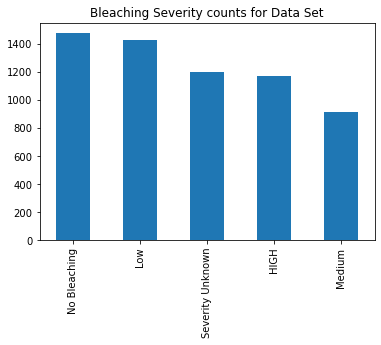

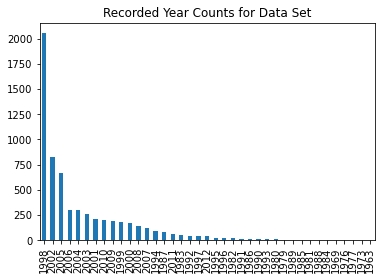

In [14]:
# Viewing Distribution of Bleaching Severity
count_severity = coral_df['BLEACHING_SEVERITY'].value_counts()
count_severity.plot(kind='bar', title="Bleaching Severity counts for Data Set")
plt.show()

# Viewing Distribution of Years for data set
count_year = coral_df['YEAR'].value_counts()
count_year.plot(kind='bar', title="Recorded Year Counts for Data Set")
plt.show()

R-squared score: 0.04


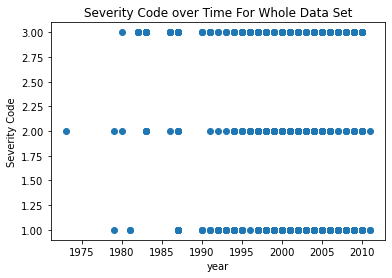

In [15]:
#Create linear regression model
lr_model = LinearRegression(fit_intercept=True)
# lr_df = coral_df[(coral_df['LAT'] < 20) & (coral_df['LAT'] > -20) & (coral_df['WATER_TEMPERATURE'] > 0)]
lr_df = coral_df[(coral_df['SEVERITY_CODE'] > 0)]
lr_df = lr_df[['YEAR', 'SEVERITY_CODE']]

x = np.array(lr_df['YEAR']).reshape(-1,1)
y = np.array(lr_df['SEVERITY_CODE']).reshape(-1,1)
lr_model = lr_model.fit(x, y)

r_squared = round(lr_model.score(x, y), 2)
print('R-squared score:', r_squared)
plt.scatter(x, y)
plt.title('Severity Code over Time For Whole Data Set')
plt.ylabel('Severity Code')
plt.xlabel('year')
plt.show()

Severity Code Legend: 
- 0 -> NO BLEACHING
- 1 -> Low
- 2 -> Medium
- 3 -> HIGH

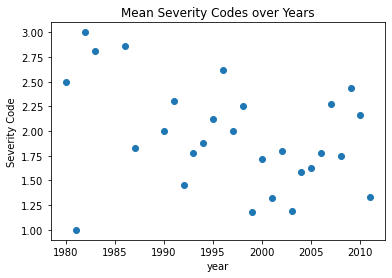

R-squared score: 0.12


In [16]:
# Attempting Linear Regression again on means for years with sample size > 10
df = lr_df[(lr_df['YEAR'] > 1979)] # only considering years with atleast 10 data points
df = df.reset_index()
# Calculating Average severity code per year 
year_avgs = {year:np.array([]) for year in df['YEAR'].unique()}
for index, row in df.iterrows():  
  year_avgs[row['YEAR']] = np.append(year_avgs[row['YEAR']],row['SEVERITY_CODE'])


for key, val in year_avgs.items():
  year_avgs[key] = round(np.mean(val), 2)

avgs = pd.Series(year_avgs)

def do_reg(averages):
  x = np.array(averages.index).reshape(-1,1)
  y = np.array(averages).reshape(-1,1)
  plt.scatter(x, y)
  plt.title('Mean Severity Codes over Years')
  plt.ylabel('Severity Code')
  plt.xlabel('year')
  plt.show()

  model = LinearRegression()
  model = model.fit(x, y)

  r_squared = round(model.score(x, y), 2)
  print('R-squared score:', r_squared)

  return model

bad_model = do_reg(avgs)

Removing Year 1981 since it seems to be outlier and refitting the model

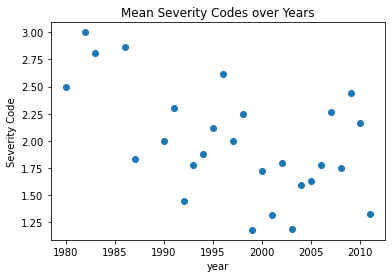

R-squared score: 0.28


In [17]:
# removing outlier and running regression again
avgs_no_outlier = avgs.drop([1981])
mean_model = do_reg(avgs_no_outlier)

Our best model seems to have score of 0.28. Here are the predictions for the next 30 years

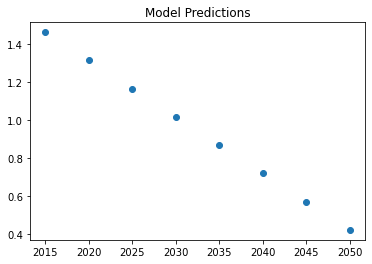

In [18]:
# model predictions
pred_years = [[2015], [2020],[2025],[2030], [2035], [2040], [2045], [2050]]
pred_sev = mean_model.predict(pred_years)
plt.title("Model Predictions")
plt.scatter(pred_years, pred_sev)
plt.show()

# Algorithm 3: Regression on the Diveristy of Species and the Mean Temprature

In [19]:
# Read in csv - supp data from nature communication study
supp_df = pd.read_csv('supp_data_2.csv')

R-squared score: 0.16


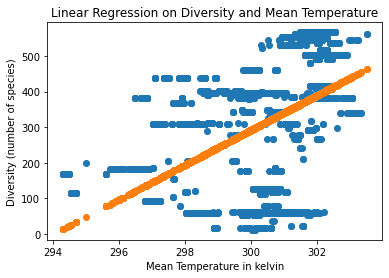

In [20]:
def linear_regression(ind_var, dep_var):
    '''Function to perform linear regression on two variables'''
    # Create linear regression model
    lr_model = LinearRegression(fit_intercept=True)
    # filter df to releveant columns
    lr_df = supp_df[[ind_var, dep_var]]
    # drop nan values
    lr_df = lr_df.dropna().reset_index(drop=True)
    # convert to x and y arrays
    X = lr_df[ind_var].values.reshape(len(lr_df), 1)
    y = lr_df[dep_var].values.reshape(len(lr_df), 1)
    # fit the linear regression model
    lr_model = lr_model.fit(X, y)
    # Get r_squared from linear regression model
    r_squared = round(lr_model.score(X, y), 2)
    print('R-squared score:', r_squared)
    # Predict y values using model
    y_predicted = lr_model.predict(X)
    # plot results
    plt.scatter(X, y)
    plt.scatter(X, y_predicted)
    plt.title('Linear Regression on Diversity and Mean Temperature')
    plt.ylabel('Diversity (number of species)')
    plt.xlabel('Mean Temperature in kelvin')
    plt.show()

# Linear regression on temperature mean and diversity in coral reefs
linear_regression('Temperature_Mean', 'Diversity')

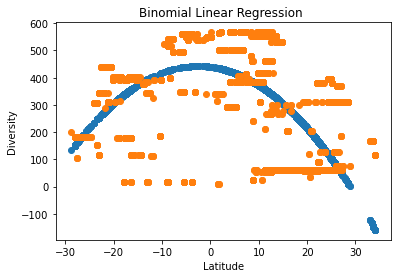

In [21]:
def poly_regression(ind_var, dep_var):
    '''Function to perform binomial linear regression'''
    # Create polynomial regression model
    poly_reg=PolynomialFeatures(degree=2, include_bias=False)
    # Create linear regression model
    lr_model = LinearRegression(fit_intercept=True)
    # Filter df to relevant columns
    lr_df = supp_df[[ind_var, dep_var]]
    # drop nan values
    lr_df = lr_df.dropna().reset_index(drop=True)
    # Create x and y arrays
    X = lr_df[ind_var].values.reshape(len(lr_df), 1)
    y = lr_df[dep_var].values.reshape(len(lr_df), 1)
    # Create transformed x values for linear regression
    poly_features = poly_reg.fit_transform(X)
    # fit to linear regression model
    lr_model.fit(poly_features, y)
    # Predict y values
    y_predicted = lr_model.predict(poly_features)
    # Plot results
    plt.scatter(X, y_predicted)
    plt.scatter(X, y)
    plt.title('Binomial Linear Regression ')
    plt.ylabel('Diversity')
    plt.xlabel('Latitude')
    plt.show()

# Polynomial Linear regression on diversity and latitude in coral reefs (north/south position of reef)
poly_regression('Latitude.Degrees', 'Diversity')